In [1]:
import pickle
import pandas as pd
import numpy as np

import xgboost as xgb
import lightgbm as lgb

from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import itertools

from keras.models import load_model
from keras.utils import np_utils

import tensorflow as tf
import pickle
import pandas as pd
import numpy as np

import xgboost as xgb
import lightgbm as lgb
import time

from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from keras import models
from keras import layers
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Dense, GaussianNoise, GaussianDropout
from keras.models import Sequential, Model
from keras.regularizers import l2, l1
from keras.optimizers import Adam, SGD, Nadam
from keras.callbacks import LearningRateScheduler
from keras.metrics import categorical_accuracy
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from  keras.regularizers import l1, l2
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(
#         visible_device_list="1", 
        allow_growth=True
    )
)

set_session(tf.Session(config=config))

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load data
df = pd.concat([
    pd.read_csv('../data/feature_selection_positive.csv', index_col=0),
    pd.read_csv('../data/decomp_pos.csv', index_col=0).drop('Subclass', axis=1)
], axis=1)

In [3]:
# divide objective and target
objective = df.Subclass
le = preprocessing.LabelEncoder()
objective = le.fit_transform(objective)

features = df.drop('Subclass', axis=1)

In [4]:
# train test split
random_state=np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    objective,
    test_size=0.2
)

In [5]:
# transform  for keras's target label
y_train_for_keras = np_utils.to_categorical(y_train)
y_test_for_keras = np_utils.to_categorical(y_test)

In [6]:
# define and fit
clf = rf()
clf = clf.fit(X_train, y_train)

# append accuracy to list
t = []
t.append(clf.score(X_test, y_test))
pickle.dump(clf, open('../model/rf_pos_fs+decomp.sav', 'wb'))

In [7]:
# setting params
params = {}
params['device'] = 'gpu'
params['gpu_id'] = 1
params['updater'] = 'grow_gpu_hist'

In [8]:
# define and fit
model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)

pickle.dump(model, open('../model/xgb_pos_fs+decomp.sav', 'wb'))
t.append(model.score(X_test, y_test))

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [9]:
# define and fit 
gbm = lgb.LGBMClassifier(
    objective='multiclass',
    device = 'gpu'
)

gbm.fit(
    X_train, 
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=5
)
pickle.dump(gbm, open('../model/lgbm_pos_fs+decomp.sav', 'wb'))
t.append(gbm.score(X_test, y_test))

[1]	valid_0's multi_logloss: 1.2921
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's multi_logloss: 1.21668
[3]	valid_0's multi_logloss: 1.14757
[4]	valid_0's multi_logloss: 1.08992
[5]	valid_0's multi_logloss: 1.03807
[6]	valid_0's multi_logloss: 0.989049
[7]	valid_0's multi_logloss: 0.948738
[8]	valid_0's multi_logloss: 0.908908
[9]	valid_0's multi_logloss: 0.87547
[10]	valid_0's multi_logloss: 0.845081
[11]	valid_0's multi_logloss: 0.815169
[12]	valid_0's multi_logloss: 0.789307
[13]	valid_0's multi_logloss: 0.767793
[14]	valid_0's multi_logloss: 0.746698
[15]	valid_0's multi_logloss: 0.728364
[16]	valid_0's multi_logloss: 0.70805
[17]	valid_0's multi_logloss: 0.692014
[18]	valid_0's multi_logloss: 0.677733
[19]	valid_0's multi_logloss: 0.662354
[20]	valid_0's multi_logloss: 0.648166
[21]	valid_0's multi_logloss: 0.635585
[22]	valid_0's multi_logloss: 0.621297
[23]	valid_0's multi_logloss: 0.612853
[24]	valid_0's multi_logloss: 0.603974
[25]	valid_0's multi

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [10]:
tf.set_random_seed(42)

# make keras model
start = time.time()
inputs = Input(shape=(X_train.shape[1],))

x = Dense(512, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(len(df['Subclass'].value_counts()), activation='softmax')(x)
model = Model(inputs=inputs, outputs=predictions)

# compile
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

# fit
epochs = 100
batch_size = 1000
es = EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(
    X_train,
    y_train_for_keras,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test_for_keras),
    verbose=1,
    callbacks=[
        es,
#         lr_decay
    ]
)

model.save('../model/Keras_pos_fs+decomp.h5')
t.append(model.evaluate(X_test, y_test_for_keras, verbose=0)[1])

Train on 1340 samples, validate on 336 samples
Epoch 1/100
1340/1340 [==============================] - 2s 1ms/step - loss: 1.9534 - acc: 0.2590 - val_loss: 1.4771 - val_acc: 0.1964
Epoch 2/100
1340/1340 [==============================] - 0s 80us/step - loss: 1.7408 - acc: 0.2724 - val_loss: 1.4057 - val_acc: 0.2262
Epoch 3/100
1340/1340 [==============================] - 0s 80us/step - loss: 1.7276 - acc: 0.2799 - val_loss: 1.4272 - val_acc: 0.2500
Epoch 4/100
1340/1340 [==============================] - 0s 96us/step - loss: 1.6241 - acc: 0.2993 - val_loss: 1.4376 - val_acc: 0.2530
Epoch 5/100
1340/1340 [==============================] - 0s 86us/step - loss: 1.6144 - acc: 0.3090 - val_loss: 1.4151 - val_acc: 0.2887
Epoch 6/100
1340/1340 [==============================] - 0s 83us/step - loss: 1.5657 - acc: 0.3075 - val_loss: 1.3979 - val_acc: 0.3155
Epoch 7/100
1340/1340 [==============================] - 0s 88us/step - loss: 1.5497 - acc: 0.3187 - val_loss: 1.3740 - val_acc: 0.3274
Ep

1340/1340 [==============================] - 0s 92us/step - loss: 0.5867 - acc: 0.7619 - val_loss: 0.8377 - val_acc: 0.6607
Epoch 61/100
1340/1340 [==============================] - 0s 91us/step - loss: 0.6042 - acc: 0.7493 - val_loss: 0.8696 - val_acc: 0.6369
Epoch 62/100
1340/1340 [==============================] - 0s 96us/step - loss: 0.5790 - acc: 0.7552 - val_loss: 0.8579 - val_acc: 0.6399
Epoch 63/100
1340/1340 [==============================] - 0s 90us/step - loss: 0.5950 - acc: 0.7545 - val_loss: 0.8158 - val_acc: 0.6607
Epoch 64/100
1340/1340 [==============================] - 0s 95us/step - loss: 0.5853 - acc: 0.7657 - val_loss: 0.8030 - val_acc: 0.6726
Epoch 65/100
1340/1340 [==============================] - 0s 93us/step - loss: 0.5448 - acc: 0.7896 - val_loss: 0.8280 - val_acc: 0.6607
Epoch 66/100
1340/1340 [==============================] - 0s 86us/step - loss: 0.5538 - acc: 0.7858 - val_loss: 0.8685 - val_acc: 0.6399
Epoch 67/100
1340/1340 [==============================

In [11]:
f = []
f.append(t)

In [12]:
f

[[0.7559523809523809,
  0.8214285714285714,
  0.8214285714285714,
  0.6964285714285714]]

In [13]:
# load data
df = pd.concat([
    pd.read_csv('../data/feature_selection_negative.csv', index_col=0),
    pd.read_csv('../data/decomp_neg.csv', index_col=0).drop('Subclass', axis=1)
], axis=1)

In [14]:
df

,Subclass,HCD35_213.12,HCD35_120.04,HCD35_110.9,HCD35_94.92,HCD35_207.97,HCD35_209.12,HCD35_157.09,HCD35_340.98,HCD35_149.1,...,NMF_0_6,NMF_1_6,NMF_2_6,NMF_3_6,NMF_4_6,FAG_0_6,FAG_1_6,FAG_2_6,FAG_3_6,FAG_4_6
0,Carbohydrates and carbohydrate conjugates,0.00,115840.83,0.0,0.00,0.00,0.00,0.00,0.0,0.00,...,442.589339,6.461387,0.387287,174.413588,0.000000,405.457511,7.421322e+06,0.00,0.00,2657055.25
1,Carbohydrates and carbohydrate conjugates,0.00,0.00,0.0,0.00,24655.70,0.00,0.00,0.0,0.00,...,150.812327,3.946795,0.165180,5.194479,1.710547,721.271907,2.419239e+06,0.00,0.00,0.00
2,Diterpenoids,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,...,14.047089,0.467921,0.110087,223.847957,0.082778,516.728416,2.988356e+05,0.00,0.00,3519268.75
3,Diterpenoids,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,...,9.400444,0.000000,0.142376,96.103889,2.059827,5681.135070,0.000000e+00,0.00,0.00,1365321.12
4,Diterpenoids,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,...,809.288524,27.439701,2.865933,10.267017,0.000000,75.498157,1.725016e+07,0.00,0.00,0.00
5,Terpene lactones,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,...,15.475825,1.710443,0.038987,1.041686,0.677962,706.989939,7.938675e+03,0.00,0.00,0.00
6,Terpene lactones,0.00,0.00,0.0,0.00,0.00,4410.74,2451.12,0.0,35710.38,...,2.298800,2.841374,0.018107,1.839290,0.221821,100.322069,3.274544e+04,15509.01,0.00,17788.40
7,Terpene lactones,0.00,0.00,0.0,0.00,0.00,200740.22,0.00,0.0,0.00,...,0.000000,0.000000,0.000000,836.882474,0.000000,397.767293,0.000000e+00,0.00,0.00,13390610.00
8,Terpene glycosides,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,...,723.109589,26.956059,0.783339,8.534370,5.242468,3325.326422,1.164435e+07,204020.34,0.00,0.00
9,Terpene lactones,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,...,3.265781,6.768076,0.000000,22.058711,394.649536,13090.178215,0.000000e+00,0.00,0.00,111571.84


In [15]:
# divide objective and target
objective = df.Subclass
le = preprocessing.LabelEncoder()
objective = le.fit_transform(objective)

features = df.drop('Subclass', axis=1)

In [16]:
# train test split
random_state=np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    objective,
    test_size=0.2
)

In [17]:
# transform  for keras's target label
y_train_for_keras = np_utils.to_categorical(y_train)
y_test_for_keras = np_utils.to_categorical(y_test)

In [18]:
# define and fit
clf = rf()
clf = clf.fit(X_train, y_train)

# append accuracy to list
t = []
t.append(clf.score(X_test, y_test))

# pickle.dump(clf, open('../model/rf_ng_fs+decomp.sav', 'wb'))

In [19]:
# setting params
params = {}
params['device'] = 'gpu'
params['gpu_id'] = 1
params['updater'] = 'grow_gpu_hist'

In [20]:
# define and fit
model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)

# pickle.dump(model, open('../model/xgb_ng_fs+decomp.sav', 'wb'))
t.append(model.score(X_test, y_test))

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [21]:
# define and fit 
gbm = lgb.LGBMClassifier(
    objective='multiclass',
    device = 'gpu'
)

gbm.fit(
    X_train, 
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=5
)

pickle.dump(gbm, open('../model/lgbm_ng_fs+decomp.sav', 'wb'))
t.append(gbm.score(X_test, y_test))

[1]	valid_0's multi_logloss: 1.29626
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's multi_logloss: 1.21581
[3]	valid_0's multi_logloss: 1.14338
[4]	valid_0's multi_logloss: 1.08105
[5]	valid_0's multi_logloss: 1.03082
[6]	valid_0's multi_logloss: 0.983502
[7]	valid_0's multi_logloss: 0.945925
[8]	valid_0's multi_logloss: 0.916086
[9]	valid_0's multi_logloss: 0.88567
[10]	valid_0's multi_logloss: 0.854912
[11]	valid_0's multi_logloss: 0.833446
[12]	valid_0's multi_logloss: 0.810472
[13]	valid_0's multi_logloss: 0.785321
[14]	valid_0's multi_logloss: 0.768878
[15]	valid_0's multi_logloss: 0.754652
[16]	valid_0's multi_logloss: 0.736802
[17]	valid_0's multi_logloss: 0.721344
[18]	valid_0's multi_logloss: 0.708579
[19]	valid_0's multi_logloss: 0.701725
[20]	valid_0's multi_logloss: 0.687257
[21]	valid_0's multi_logloss: 0.67464
[22]	valid_0's multi_logloss: 0.663155
[23]	valid_0's multi_logloss: 0.655867
[24]	valid_0's multi_logloss: 0.647212
[25]	valid_0's mult

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [22]:
y_pred = gbm.predict(X_test)

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [23]:
# plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=16)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

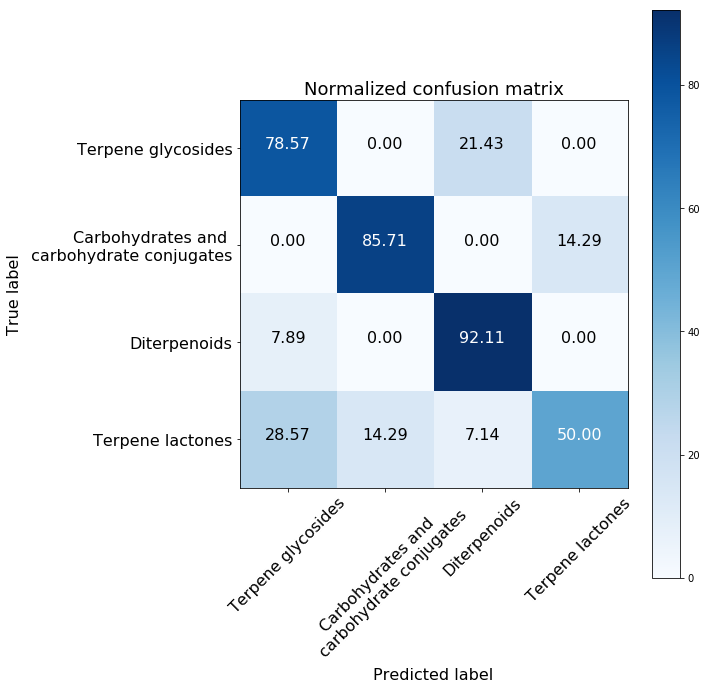

In [24]:
# set name list
class_names = list(df.Subclass.value_counts().index)
class_names[1] = 'Carbohydrates and \n carbohydrate conjugates'

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [25]:
tf.set_random_seed(42)

# make keras model
start = time.time()
inputs = Input(shape=(X_train.shape[1],))

x = Dense(512, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(len(df['Subclass'].value_counts()), activation='softmax')(x)
model = Model(inputs=inputs, outputs=predictions)

# compile
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

# fit
epochs = 100
batch_size = 1000
es = EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(
    X_train,
    y_train_for_keras,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test_for_keras),
    verbose=1,
    callbacks=[
        es,
#         lr_decay
    ]
)

model.save('../model/Keras_ng_fs+decomp.h5')
t.append(model.evaluate(X_test, y_test_for_keras, verbose=0)[1])

Train on 373 samples, validate on 94 samples
Epoch 1/100
373/373 [==============================] - 1s 3ms/step - loss: 2.2294 - acc: 0.2252 - val_loss: 1.4013 - val_acc: 0.4043
Epoch 2/100
373/373 [==============================] - 0s 53us/step - loss: 1.8421 - acc: 0.3405 - val_loss: 1.3925 - val_acc: 0.4255
Epoch 3/100
373/373 [==============================] - 0s 63us/step - loss: 1.8700 - acc: 0.2708 - val_loss: 1.4616 - val_acc: 0.4468
Epoch 4/100
373/373 [==============================] - 0s 70us/step - loss: 1.6848 - acc: 0.3512 - val_loss: 1.5222 - val_acc: 0.4574
Epoch 5/100
373/373 [==============================] - 0s 68us/step - loss: 1.7106 - acc: 0.3003 - val_loss: 1.5856 - val_acc: 0.4574
Epoch 6/100
373/373 [==============================] - 0s 75us/step - loss: 1.6867 - acc: 0.3592 - val_loss: 1.5904 - val_acc: 0.4574
Epoch 7/100
373/373 [==============================] - 0s 68us/step - loss: 1.7134 - acc: 0.3324 - val_loss: 1.5525 - val_acc: 0.4574
Epoch 8/100
373/37

In [26]:
f.append(t)

In [27]:
pd.DataFrame(
    f, 
    columns=['Random Forest', 'XGBoost', 'LightGBM', 'Keras'], 
    index=['Feature Selection + Decomposition_Positive', 'Feature Selection + Decomposition_Negative']
)

,Random Forest,XGBoost,LightGBM,Keras
Feature Selection + Decomposition_Positive,0.755952,0.821429,0.821429,0.696429
Feature Selection + Decomposition_Negative,0.702128,0.765957,0.808511,0.563830


In [28]:
pd.DataFrame(
    f, 
    columns=['Random Forest', 'XGBoost', 'LightGBM', 'Keras'], 
    index=['Feature Selection + Decomposition_Positive', 'Feature Selection + Decomposition_Negative']
).T.to_csv('../result/Feature Selection + Decomposition.csv')